Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/le-
[nltk_data]     cuong/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
2025-09-10 01:30:09.348596: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-10 01:30:09.386817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-10 01:30:10.230552: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the en

Load the Dataset

In [2]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
data.shape

(5171, 4)

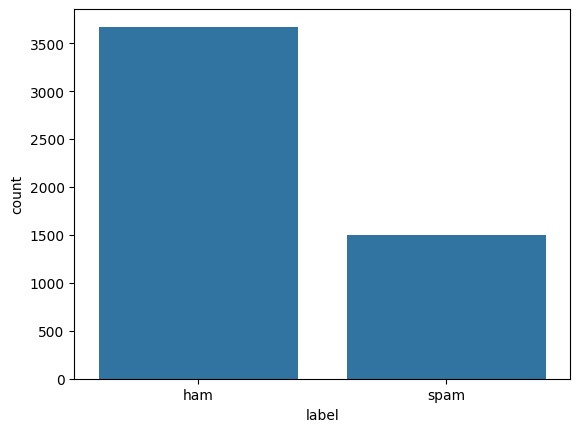

In [4]:
sns.countplot(x='label', data=data)
plt.show()

Balance the Dataset

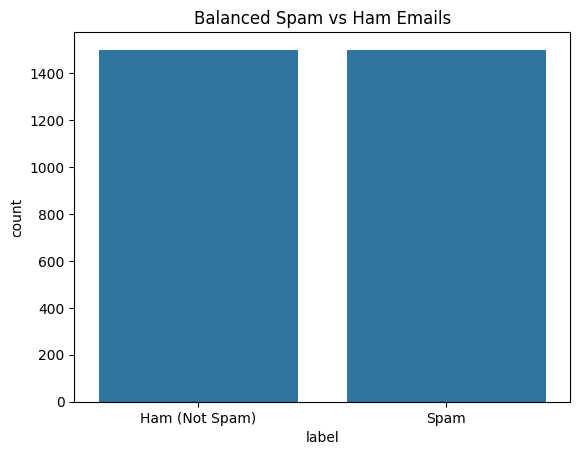

In [5]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# Downsample Ham emails to match Spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# Visualize the balanced dataset
sns.countplot(x='label', data=balanced_data)
plt.title('Balanced Spam vs Ham Emails')
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

Clean the Text

In [6]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject:', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco - big cowboy\r\ndarren :\r\ni ' m not ...,0
1,2982,ham,feb 01 prod : sale to teco gas processing\r\n...,0
2,2711,ham,"california energy crisis\r\ncalifornia  , s ...",0
3,3116,ham,re : nom / actual volume for april 23 rd\r\nw...,0
4,1314,ham,eastrans nomination changes effective 8 / 2 /...,0


In [7]:
punctuations_list = string.punctuation

def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [10]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)
    
    output = " ".join(imp_words) 
    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


Visualizing Word Cloud

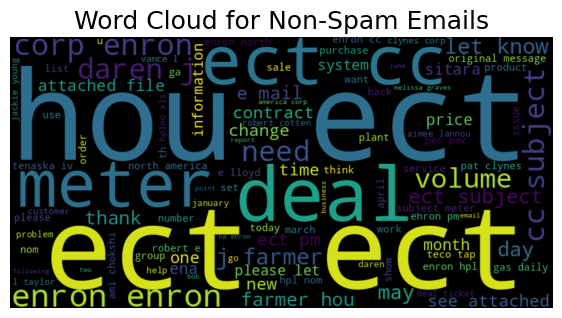

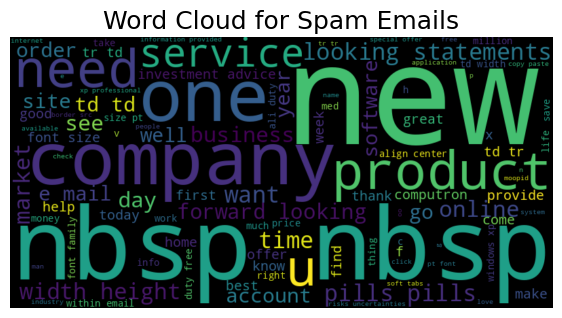

In [11]:
def plot_word_cloud(data, typ):
    email_corpus = ' '.join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word Cloud for {typ} Emails', fontsize=18)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

Tokenization and Padding

In [12]:
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100 # Maximum length of sequences
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

Define the Model

- Embedding Layer: Learns vector representations of words.
- LSTM Layer: Captures patterns in sequences.
- Fully Connected Layer: Extracts relevant features.
- Output Layer: Predicts whether an email is spam or not.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # Output layer
])

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

model.summary()

I0000 00:00:1757444178.961200   27987 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3856 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [14]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences,test_Y),
    epochs=200,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/200


2025-09-10 02:00:46.248230: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5951 - loss: 0.6772 - val_accuracy: 0.9333 - val_loss: 0.4308 - learning_rate: 0.0010
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9479 - loss: 0.2332 - val_accuracy: 0.9600 - val_loss: 0.1683 - learning_rate: 0.0010
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9591 - loss: 0.1714 - val_accuracy: 0.9583 - val_loss: 0.1722 - learning_rate: 0.0010
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9679 - loss: 0.1410 - val_accuracy: 0.9617 - val_loss: 0.1623 - learning_rate: 0.0010
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9721 - loss: 0.1249 - val_accuracy: 0.9633 - val_loss: 0.1554 - learning_rate: 0.0010
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9771 - loss: 0.1031 - val_accuracy: 0.9617 - val_loss: 0.1685 - learning_rate: 0.0010
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9696 - loss: 0.1244 - val_accuracy: 

In [15]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9800 - loss: 0.0887
Test loss: 0.08870110660791397
Test accuracy: 0.9800000190734863


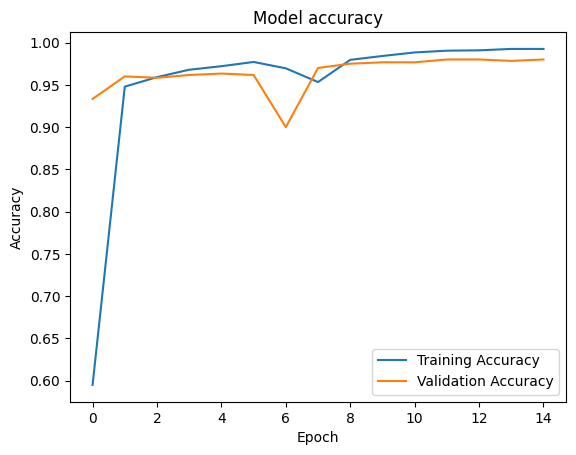

In [16]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()